<a href="https://colab.research.google.com/github/Alokik-29/Project_1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install dependencies
!pip install librosa soundfile matplotlib numpy

In [2]:
import os,sys,random,math
from pathlib import Path
import numpy as np
import pandas as pd
import librosa,librosa.display
import torchaudio
import torch
import matplotlib.pyplot as plt
from IPython.display  import Audio,display
from sklearn.model_selection import train_test_split

#reproducibility
SEED=42
random.seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#mtplotlib defaults
plt.rcParams["figure.figsize"]=(10,4)
plt.rcParams["axes.grid"]=True

print("Librosa:", librosa.__version__)
print("Torchaudio:", torchaudio.__version__)


Librosa: 0.11.0
Torchaudio: 2.8.0+cu126


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [4]:
dataset_path="/kaggle/input/ravdess-emotional-speech-audio"

In [5]:
#emotion labell mapping from RAVDESS dataset
emotion_map={
    "01":"neutral",
    "02":"calm",
    "03":"happy",
    "04":"sad",
    "05":"angry",
    "06":"fearful",
    "07":"disgust",
    "08":"surprised"
}

In [10]:
#getting all audio file path
audio_files=list(Path(dataset_path).rglob("*.wav"))

#extracting labels from file name
labels=[]
for file in audio_files:

    filename = file.name  # just the filename, e.g., "03-01-01-01-01-01-01.wav"
    emotion_code = filename.split("-")[2]  # third part indicates emotion
    labels.append(emotion_map[emotion_code])

df=pd.DataFrame({
    "file_path":audio_files,
    "label":labels
})

df=df.sample(frac=1,random_state=SEED).reset_index(drop=True)
df.head()

,file_path,label
0,/kaggle/input/ravdess-emotional-speech-audio/A...,calm
1,/kaggle/input/ravdess-emotional-speech-audio/a...,fearful
2,/kaggle/input/ravdess-emotional-speech-audio/a...,sad
3,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
4,/kaggle/input/ravdess-emotional-speech-audio/A...,sad


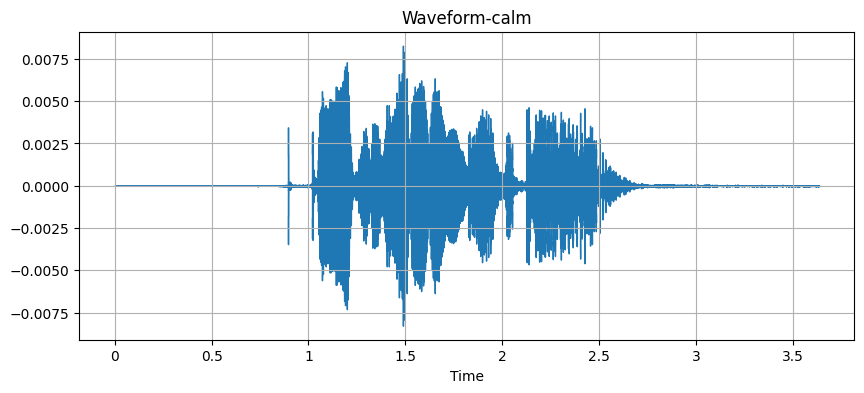

In [12]:
#pick a random sample
sample_file=df['file_path'][0]
sample_label=df['label'][0]

#displaay audio player

#load waveform
y,sr=librosa.load(sample_file,sr=None)
plt.figure()
librosa.display.waveshow(y,sr=sr)
plt.title(f"Waveform-{sample_label}")
plt.show()

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio

#Define a transform function to convert audio to Mel Spectrogram
def mel_spectrogram_transform(y, sr, n_mels=64, n_fft=1024, hop_length=512, max_len=400):
    waveform = torch.tensor(y).unsqueeze(0)
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )(waveform)
    mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

    # Pad or truncate to max_len (time dimension)
    if mel_spec.shape[2] < max_len:
        pad_amount = max_len - mel_spec.shape[2]
        mel_spec = torch.nn.functional.pad(mel_spec, (0, pad_amount))
    else:
        mel_spec = mel_spec[:, :, :max_len]

    return mel_spec


In [43]:
# Ensure only valid .wav files
if 'file_path' in df.columns:
    df = df[df['file_path'].apply(lambda x: str(x).endswith(".wav"))].copy()
else:
    raise KeyError("The DataFrame does not have a 'file_path' column.")

# Ensure labels are valid strings in emotion_map
valid_labels = list(emotion_map.values())
df = df[df['label'].isin(valid_labels)].reset_index(drop=True)

print(f"Total samples after filtering valid labels: {len(df)}")
print(df['label'].value_counts())

# Check for any empty or invalid labels
empty_labels = df[df['label'].apply(lambda x: x in ['', [], None])]
print("Rows with empty/invalid labels:")
print(empty_labels)

#  Remove rows with empty/invalid labels
df = df[df['label'].apply(lambda x: x not in ['', [], None])].reset_index(drop=True)

print(f"Total samples after removing empty labels: {len(df)}")


Total samples after filtering valid labels: 2880
label
calm         384
fearful      384
sad          384
disgust      384
angry        384
surprised    384
happy        384
neutral      192
Name: count, dtype: int64
Rows with empty/invalid labels:
Empty DataFrame
Columns: [file_path, label]
Index: []
Total samples after removing empty labels: 2880


In [44]:
# Filter DataFrame first
valid_labels = list(emotion_map.values())
df = df[df['label'].isin(valid_labels)].reset_index(drop=True)

print(f"Total samples after filtering: {len(df)}")
print(df['label'].value_counts())

# Custom Dataset class
class RAVDESSDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_list = list(emotion_map.values())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = str(self.df.iloc[idx]['file_path'])
        label = self.df.iloc[idx]['label']  # <-- define label here

        # Load audio
        y, sr = librosa.load(file_path, sr=None)

        # Apply transform if any
        if self.transform:
            y = self.transform(y, sr)

        # Convert label to index safely
        if label not in self.label_list:
            raise ValueError(f"Invalid label found: {label}")
        label_idx = self.label_list.index(label)

        return y, label_idx



Total samples after filtering: 2880
label
calm         384
fearful      384
sad          384
disgust      384
angry        384
surprised    384
happy        384
neutral      192
Name: count, dtype: int64


In [45]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])

train_dataset = RAVDESSDataset(train_df, transform=mel_spectrogram_transform)
test_dataset = RAVDESSDataset(test_df, transform=mel_spectrogram_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

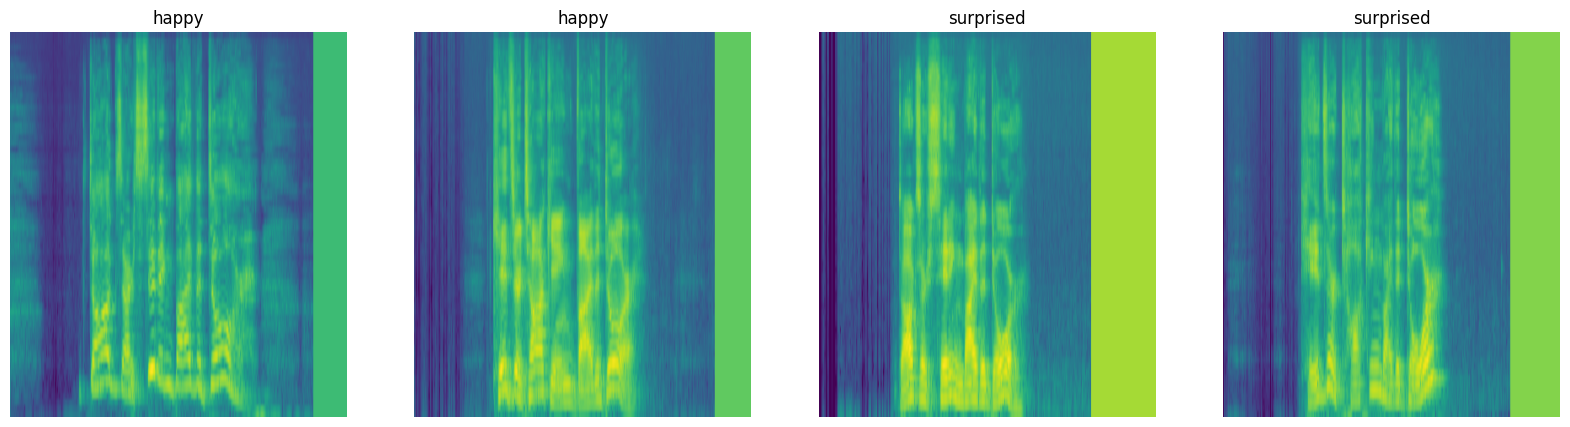

In [48]:
#get abatch of data
batch=next(iter(train_loader))
x_batch,y_batch=batch # X_batch: Mel spectrograms, y_batch: labels
#plotting first four sample
fig,axes=plt.subplots(1,4,figsize=(20,5))
for i in range(4):
  mel=x_batch[i].squeeze(0).numpy()
  label_idx=y_batch[i].item()
  label=list(emotion_map.values())[label_idx]

  axes[i].imshow(mel,origin='lower',aspect='auto',cmap='viridis')
  axes[i].set_title(label)
  axes[i].axis('off')

plt.show()

In [ ]:
from transformers import ASTForAudioClassification, ASTFeatureExtractor
